In [1]:
%pylab inline
data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
stamp_size=64
pixel_scale=0.03
k_scale=2. * np.pi / (pixel_scale * stamp_size)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
# First step is to find an HST PSF that will work for all images,
# we are taking a random sample of 1000 psfs, take the largest one,
# and dilate it a little bit with GalSim
cat = galsim.COSMOSCatalog(dir=data_dir)
psfs = []
psfs_fwhm = []
npsfs = 5000

# Build isotropic PSf
stamp_size=128
pixel_scale=0.03
kscale=2. *  np.pi / (pixel_scale * stamp_size)

ims_r = [ ]

for i in range(npsfs):
    gal = cat.makeGalaxy(i)
    psfs.append(gal.original_psf)
    psfs_fwhm.append(gal.original_psf.calculateFWHM())
    im = gal.original_psf.drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale)
    ims_r.append(abs(im.array))

/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [3]:
i_psf_max = np.argmax(array(psfs_fwhm))
psf_max = psfs[i_psf_max]

i_psf_min = np.argmin(array(psfs_fwhm))
psf_min = psfs[i_psf_min]

In [4]:
# Build reference PSF
ref_psf = galsim.InterpolatedKImage(galsim.ImageCD(abs(array(ims_r)).min(axis=0) +0j, scale=kscale))

# Apply transform to make isotropic
ims_r2 = [ ]
for i in range(360):
    im = ref_psf.rotate(galsim.Angle(i*np.pi/180., galsim.radians)).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale)
    ims_r2.append(abs(im.array))

mat = abs(array(ims_r2)).min(axis=0)
mat = mat + mat.T
effective_psf = galsim.InterpolatedKImage(galsim.ImageCD(mat+0j, scale=kscale))
# Apply some dilation and normalize the PSF
#effective_psf = effective_psf.dilate(1.01).withFlux(1.)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


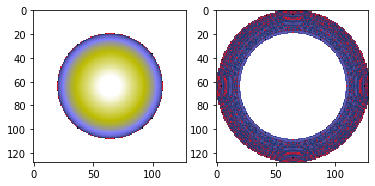

In [36]:
# Truncating psf to remove the zeros at the edges
mask = log10(mat/mat.max()) > -4.5 
subplot(121)
imshow(log10(mat*mask)  ,cmap='gist_stern',vmax=0); #colorbar()
subplot(122)
imshow(log10(mat*(1-mask))  ,cmap='gist_stern',vmax=0); #colorbar()

In [40]:
# Cropping the PSF image
coords = np.argwhere(mask)
x_min, y_min = coords.min(axis=0)
x_max, y_max = coords.max(axis=0)
cropped = (mask*mat)[x_min:x_max+1, y_min:y_max+1]

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


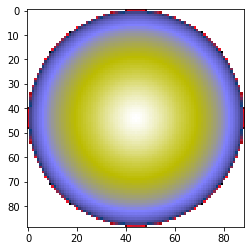

In [41]:
imshow(log10(cropped),cmap='gist_stern'); #colorbar()

In [69]:
effective_psf = galsim.InterpolatedKImage(galsim.ImageCD(cropped+0j, scale=kscale))

In [70]:
nyquist_scale = effective_psf.nyquist_scale
dilation_ratio = 0.168/nyquist_scale

In [71]:
dilation_ratio

3.8500000000000005

In [72]:
# Get the nyquist frequency of  this PSF
effective_psf = effective_psf.dilate(3.9).withFlux(1.)

Populating the interactive namespace from numpy and matplotlib


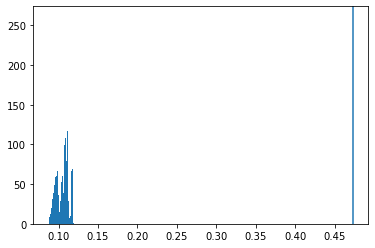

In [73]:
%pylab inline
hist(array(psfs_fwhm),100);
axvline(effective_psf.calculateFWHM())

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


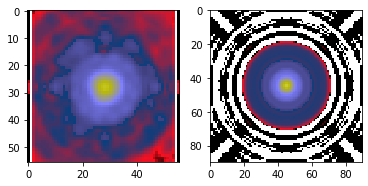

In [74]:
subplot(121)
imshow(log10(psf_max.drawImage().array),cmap='gist_stern',vmin=-6,vmax=0); 
subplot(122)
imshow(log10(effective_psf.drawImage().array),cmap='gist_stern',vmin=-6,vmax=0);

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'non isotropic avg psf')

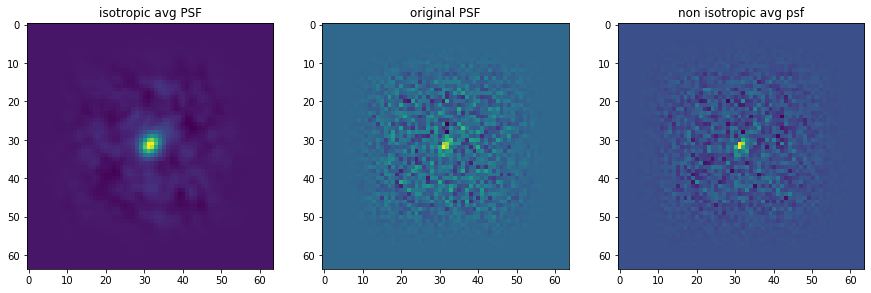

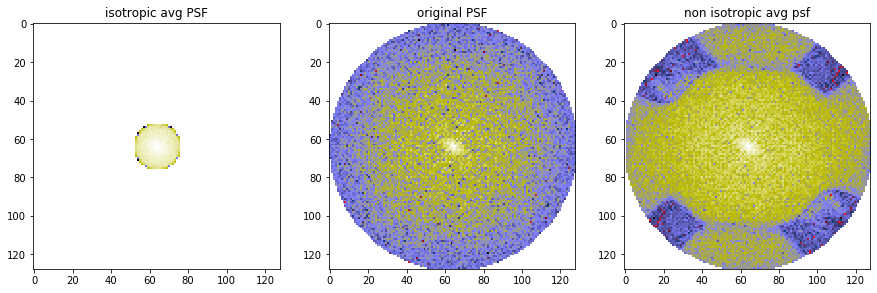

In [77]:
figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.168)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(132)
galsim.Convolve(gal, gal.original_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('original PSF')
subplot(133)
galsim.Convolve(gal, ref_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('non isotropic avg psf')

figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(132)
imshow(log10(abs(galsim.Convolve(gal, gal.original_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('original PSF')
subplot(133)
imshow(log10(abs(galsim.Convolve(gal, ref_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('non isotropic avg psf')

In [76]:
from astropy.io import fits
# Exporting the effective PSF
im = effective_psf.drawImage(nx=100,ny=100, scale=0.168)
fits.writeto('../data/hsc_cosmos_effective_psf.fits', im.array, clobber=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


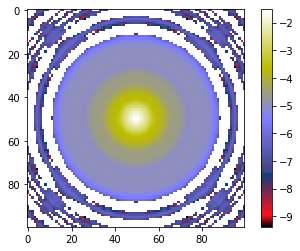

In [9]:
imshow(log10(im.array),cmap='gist_stern');colorbar()

In [10]:
effective_psf

NameError: name 'effe' is not defined